<a href="https://colab.research.google.com/github/cahmtoledo/RVWorks/blob/master/EP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EP2 - Carmen Toledo
NUSP: 10355190
1. Construa um gráfico para visualizar a série temporal

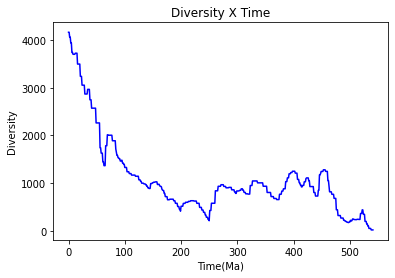

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


url = "https://raw.githubusercontent.com/cahmtoledo/RVWorks/master/diversity.csv"

table = pd.read_csv(url, delimiter=';')

time = np.asarray(table['Time(Ma)'])
diversity = np.asarray(table["Diversity"])
#time = np.asarray(table.iloc[:,0])
#diversity = np.asarray(table.iloc[:,1])


plt.title("Diversity X Time")
plt.xlabel("Time(Ma)")
plt.ylabel("Diversity")
plt.plot(diversity, color='b')



2. Ajuste por um polinômio de terceiro grau

(542, 1)


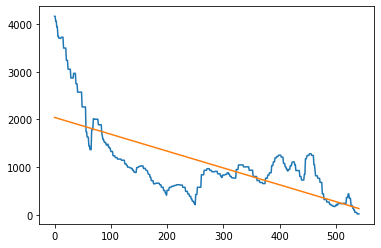

In [13]:
from sklearn.linear_model import LinearRegression

time=time.reshape(-1,1)
#diversity.reshape(-1,1)
print(np.shape(time))

model = LinearRegression()
model.fit(time , diversity)
y= model.predict(time)

plt.plot(diversity)
plt.plot(y)


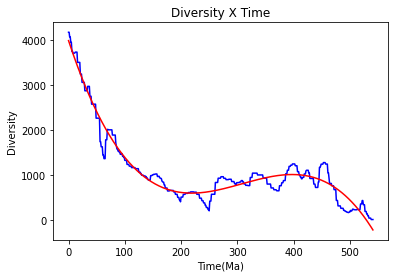

In [14]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 3)

x = poly.fit_transform(time)
poly_reg = LinearRegression()

poly_reg.fit(x, diversity)
y=poly_reg.predict(x)

plt.title("Diversity X Time")
plt.xlabel("Time(Ma)")
plt.ylabel("Diversity")
plt.plot(diversity, color='b')
plt.plot(y, color = 'r')


3. Gráfico sem o polinômio

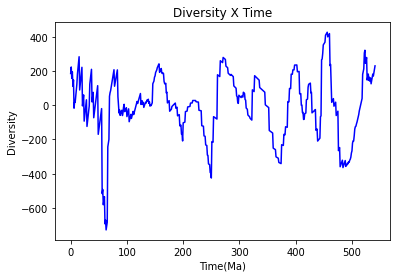

In [15]:
newyOriginal = diversity-y

plt.title("Diversity X Time")
plt.xlabel("Time(Ma)")
plt.ylabel("Diversity")
plt.plot(newyOriginal, color='b')


4. Calculando o espectro de Fourier

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


<BarContainer object of 270 artists>

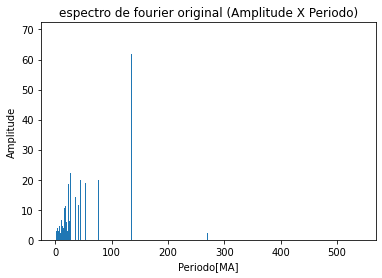

In [16]:
fft = np.fft.fft(newyOriginal)

N=newyOriginal.size
T=time[1]-time[0]

freq = np.linspace(0, 1/T, N)
periodo = 1/freq
periodo = periodo.reshape(-1)

plt.title ("espectro de fourier original (Amplitude X Periodo)")
plt.ylabel("Amplitude")
plt.xlabel("Periodo[MA]")


plt.bar(periodo[1:N//2], np.abs(fft)[1:N//2] * 1/N, )


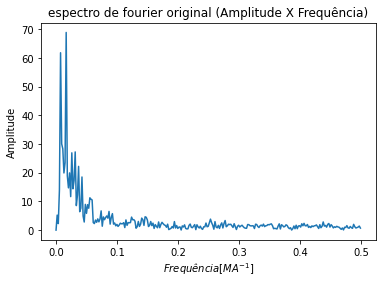

In [17]:
freq = freq.reshape(-1)

plt.title ("espectro de fourier original (Amplitude X Frequência)")
plt.ylabel("Amplitude")
plt.xlabel(r'$Frequência[MA^{-1}]$')



plt.plot(freq[:N//2], np.abs(fft)[:N//2] * 1/N)


5. Verificaremos a relevância estatísitica, para tal:

1) Calculamos as variações em cada passo da série temporal

2) embaralhamos a sequência milhares de vezes e para cada embaralhamento construimos uma nova série temporal a partir de n(0)

3) para cada amostra, repetimos a interpolação polinomial, seguida de subtração do e espectro de Fourier

4) Para cada frequência do espectro, ordenamos os valores de potência obtidos do menor para o maior. Selecionamos o valor que é maior do que 95% dos valores produzidos

5) Produzimos um espectro composto pelos valores escolhidos e sobrepomos ao espectro original. Esse é o espectro de background

6) sobrepomos o espectro de backgroundo ao original, apenas as frequências acima da curva de background são relevantes

6. Faremos o que foi descrito acima

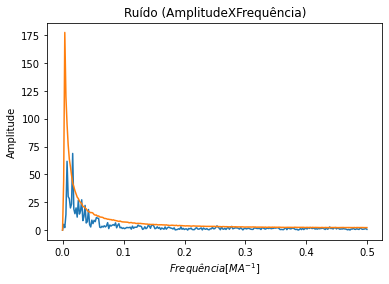

In [19]:
import random

tempos = time.reshape(-1)
deltaN = [(diversity[i]-diversity[i-1]) for i in range(1, diversity.size)]
def generateSample():
#a
  random.shuffle(deltaN)

  newdiversity = []

  #b
  newdiversity.append(diversity[0])
  for i in range(len(deltaN)):
    newdiversity.append(newdiversity[i]+deltaN[i])

  #c
  coef = np.polyfit(tempos, newdiversity, 3)

  pol = np.poly1d(coef)

  ''' Isso foi feito para testar se tava dando certo
  plt.title("new series newDiversiry X Time")
  plt.xlabel("Time(Ma)")
  plt.ylabel("Diversity")
  plt.plot(newdiversity, color='b')
  plt.plot(pol(tempos))
  '''

  newy = newdiversity-pol(tempos)

  '''
  plt.title("new series newDiversiry X Time")
  plt.xlabel("Time(Ma)")
  plt.ylabel("Diversity")
  plt.plot(newy)
  '''

  newfft = np.fft.fft(newy)

  '''
  plt.title ("novo espectro de fourier original (Amplitude X Frequência)")
  plt.ylabel("Amplitude")
  plt.xlabel(r'$Frequência[MA^{-1}]$')
  plt.plot(freq[:N//2], np.abs(newfft)[:N//2] * 1/N)
  '''
  return np.abs(newfft)

#d
sample = generateSample()
samplefft = [[sample[j]] for j in range(N//2)]
for i in range(999):
  sample = generateSample()
  for j in range(N//2):
    samplefft[j].append(sample[j])


#Vamos ordenar e pegar um valor maior que 95%, 95% de 1000 = 950
ruido = []
for i in range(len(samplefft)):
  samplefft[i].sort()
  ruido.append(samplefft[i][950])


plt.title ("Ruído (AmplitudeXFrequência)")
plt.ylabel("Amplitude")
plt.xlabel(r'$Frequência[MA^{-1}]$')
plt.plot(freq[:N//2], np.abs(fft)[:N//2] * 1/N)
plt.plot(freq[:N//2], np.asarray(ruido)*1/N)



[0.0166358595194085, 0.031423290203327174, 0.03696857670979667, 0.04251386321626617, 0.2532347504621072, 0.27726432532347506, 0.4066543438077634, 0.43807763401109057]


<BarContainer object of 8 artists>

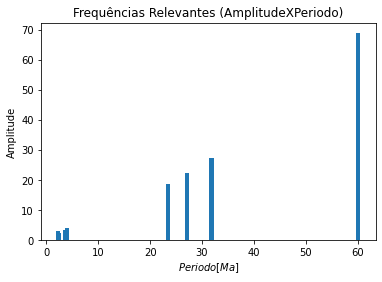

In [20]:
fftrelevante = []
freqrelevante = []

for i in range(N//2):
  if (np.abs(fft[i])>ruido[i]):
    fftrelevante.append(np.abs(fft)[i])
    freqrelevante.append(freq[i])
periodorelevante = 1 / np.asarray(freqrelevante)

print(freqrelevante)

plt.title("Frequências Relevantes (AmplitudeXPeriodo)")
plt.ylabel("Amplitude")
plt.xlabel(r'$Periodo [Ma]$')
plt.bar(periodorelevante, np.asarray(fftrelevante) * 1/N, )



7) Conclusões:

Após o procedimento descrit ao longo do documento chegamos a um gráfico onde é possível observar quais frequências são relevantes por terem uma amplitude maior que o ruído e portanto provavelmente não serem aleatórias.